# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### Response 
In this business context, the price of the used car is the dependent variable or 'target'. 

Our goal is to predict the target using the available data on drivers of the price, i.e., the features of the model. 

In essence, we need to build a regression model with lowest possible error. The features of that model are the key drivers for used car prices. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

##### Response 
Steps that I would take: 
1. Read the column names and check the summary statistics. For categorical columns, check the unique values in each column.
2. Check for duplicate rows in the dataset and remove if appropriate.
3. Check the null values for variables. Drop any variable with high missing rate.

In [24]:
# Import libraries/packages with proper alias
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display="diagram")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

In [25]:
# Reading data into a pandas data frame --- Demonstrates competency with pandas
df_cars_raw = pd.read_csv('/workspaces/codespaces-jupyter/data/vehicles.csv')
df_cars_raw.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [26]:
# Check whether the data has any duplicates --- Demonstrates competency with pandas 
duplicates = df_cars_raw.duplicated()
duplicate_rows = df_cars_raw[duplicates]
duplicate_rows.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state


In [27]:
# Check whether the id column alone has any duplicates 
duplicates = df_cars_raw[['id']].duplicated()
duplicate_rows = df_cars_raw[duplicates]
duplicate_rows.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state


**Duplicate check conclusion:** There are no duplicate rows in the dataset. 

In [28]:
# Check the data type of each column --- Demonstrates competency with pandas
df_cars_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

**Conclusion from info():** 
1. Drop cylinders, VIN, drive, size and paint_color columns due to the high missing rate. Also drop region because the unusably high number of unique values without any inherent clear relationship to the target. 
2. Although condition column also has a high missing rate, we can impute the data instead of deleting the column. Not providing the used car condition could also mean something.
3. Remove rows with missing data. 

In [29]:
# Check summary stats for numerical columns --- Demonstrates competency with pandas
df_cars_raw.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


/home/codespace/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'Frequency')

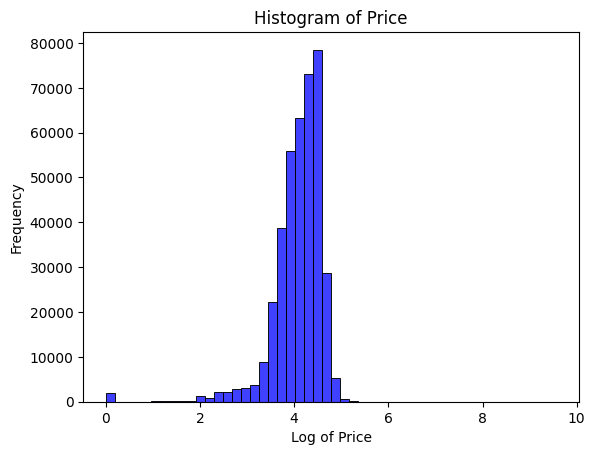

In [30]:
# Create historgram of the price. Since price has a big range we can plot log of price instead. --- Demonstrates competency with seaborn
sns.histplot(np.log10(df_cars_raw['price']), bins=50, kde=False, color='blue')
# Add title and labels to the plot to improve readability 
plt.title('Histogram of Price') 
plt.xlabel('Log of Price')
plt.ylabel('Frequency')

**Conclusion from describe():**
The summary statistics show that there are some very expensive cars (outliers) in the dataset and some very old cars as well (based on the min year = 1900). These cars would skew the model for most cars so we should remove these. 

In [31]:
df_cars_raw['condition'].unique() #Shows that this is an ordinal variable

array([nan, 'good', 'excellent', 'fair', 'like new', 'new', 'salvage'],
      dtype=object)

In [32]:
df_cars_raw['manufacturer'].unique()

array([nan, 'gmc', 'chevrolet', 'toyota', 'ford', 'jeep', 'nissan', 'ram',
       'mazda', 'cadillac', 'honda', 'dodge', 'lexus', 'jaguar', 'buick',
       'chrysler', 'volvo', 'audi', 'infiniti', 'lincoln', 'alfa-romeo',
       'subaru', 'acura', 'hyundai', 'mercedes-benz', 'bmw', 'mitsubishi',
       'volkswagen', 'porsche', 'kia', 'rover', 'ferrari', 'mini',
       'pontiac', 'fiat', 'tesla', 'saturn', 'mercury', 'harley-davidson',
       'datsun', 'aston-martin', 'land rover', 'morgan'], dtype=object)

In [33]:
df_cars_raw['title_status'].unique()

array([nan, 'clean', 'rebuilt', 'lien', 'salvage', 'missing',
       'parts only'], dtype=object)

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [34]:
# Drop columns
df_cars_temp = df_cars_raw.drop(columns=['region','model','cylinders','VIN','drive','size','paint_color'])

# Impute value in the condition column
df_cars_temp['condition'] = df_cars_temp['condition'].fillna('Unknown')

# Calculate the 5th and 95th percentile for the 'price' column and 95th percentile for 'odometer' column
price_5th_percentile = df_cars_temp['price'].quantile(0.05)
price_95th_percentile = df_cars_temp['price'].quantile(0.95)
odometer_95th_percentile = df_cars_temp['odometer'].quantile(0.95)

# Filter the data for price, odometer and year outliers
df_cars_temp = df_cars_temp[(df_cars_temp['price'] >= price_5th_percentile) & (df_cars_temp['price'] <= price_95th_percentile) & (df_cars_temp['odometer'] <= odometer_95th_percentile) & (df_cars_temp['year'] >= 1920)]

# Drop the NaN rows. Named the resulting data frame as "df_cars_clean" to indicate clean dataset
df_cars_clean = df_cars_temp.dropna().drop(columns=['id'])
df_cars_clean.head()

,price,year,manufacturer,condition,fuel,odometer,title_status,transmission,type,state
27,33590,2014.0,gmc,good,gas,57923.0,clean,other,pickup,al
28,22590,2010.0,chevrolet,good,gas,71229.0,clean,other,pickup,al
29,39590,2020.0,chevrolet,good,gas,19160.0,clean,other,pickup,al
30,30990,2017.0,toyota,good,gas,41124.0,clean,other,pickup,al
31,15000,2013.0,ford,excellent,gas,128000.0,clean,automatic,truck,al


Text(0, 0.5, 'Price')

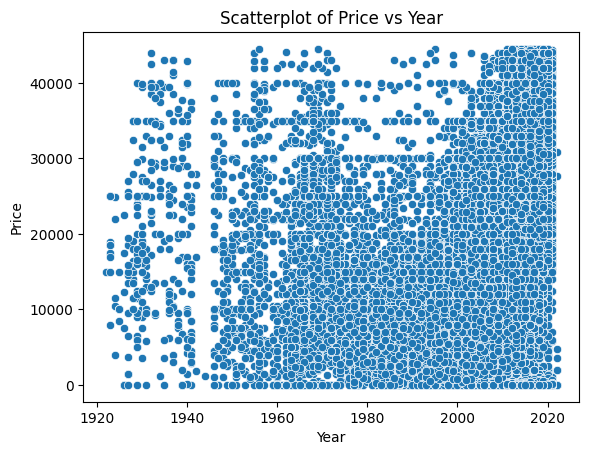

In [35]:
# Create scatter plot of price vs year using seaborn libary. --- Demonstrates competency with seaborn
sns.scatterplot(data=df_cars_clean, x='year', y='price')
# Add title and labels to the plot to improve readability 
plt.title('Scatterplot of Price vs Year')
plt.xlabel('Year')
plt.ylabel('Price')

Text(0.5, 1.0, 'Boxplot of Price vs Year Binned into 10 Ranges')

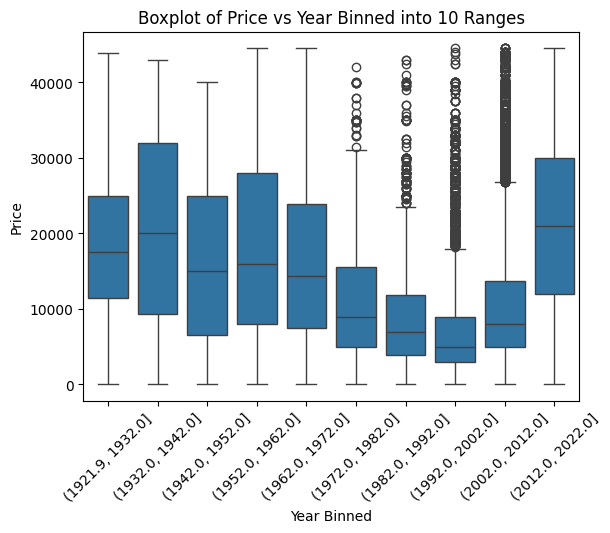

In [36]:
# Since the chart above is not very helpful, we can create bins of the Year columns and use boxplot instead. 
# Define the number of bins
num_bins = 10

# Calculate the bin edges
bin_edges = pd.cut(df_cars_clean['year'], bins=num_bins)

# Add the binned year as a new column in the DataFrame
df_cars_clean['year_binned'] = bin_edges

# Create the boxplot
sns.boxplot(x='year_binned', y='price', data=df_cars_clean)

# Rotate x labels for better readability
plt.xticks(rotation=45)

# Set labels and title
plt.xlabel('Year Binned')
plt.ylabel('Price')
plt.title('Boxplot of Price vs Year Binned into 10 Ranges')


**Conclusion:** This boxplot clearly shows that as price actually increases as Year goes more into history but only before 1992. I consider this as vintage car effect. From a modeling standpoint, we need to build 2 separate models: (1) regular cars, i.e., those with Year >= 1990 (round number near the bin edge of 1992), (2) vintage cars, i.e., those with Year < 1990. For this modeling exercise, we will focus on regular cars model. 

Text(0, 0.5, 'Price')

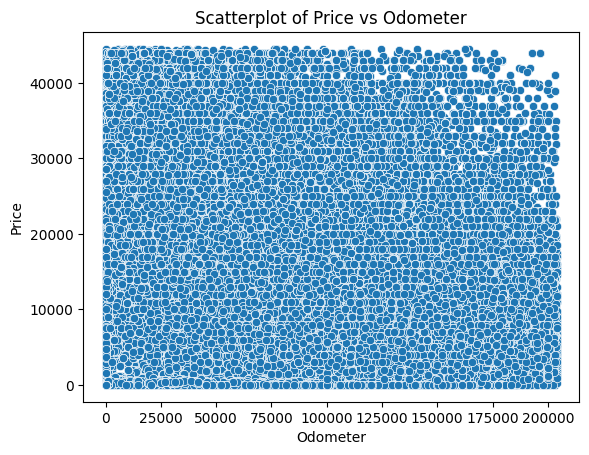

In [37]:
sns.scatterplot(data=df_cars_clean, x='odometer', y='price')
plt.title('Scatterplot of Price vs Odometer')
plt.xlabel('Odometer')
plt.ylabel('Price')

Text(0.5, 1.0, 'Boxplot of Price vs Odometer Binned into 10 Ranges')

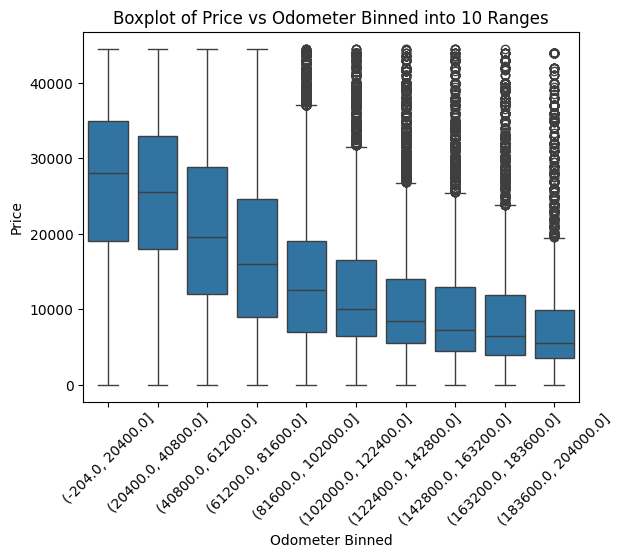

In [38]:
# Again - since the chart above is not very helpful, we can create bins of the Odometer columns and use boxplot instead. 
# Define the number of bins
num_bins = 10

# Calculate the bin edges
bin_edges = pd.cut(df_cars_clean['odometer'], bins=num_bins)

# Add the binned year as a new column in the DataFrame
df_cars_clean['odometer_binned'] = bin_edges

# Create the boxplot
sns.boxplot(x='odometer_binned', y='price', data=df_cars_clean)

# Rotate x labels for better readability
plt.xticks(rotation=45)

# Set labels and title
plt.xlabel('Odometer Binned')
plt.ylabel('Price')
plt.title('Boxplot of Price vs Odometer Binned into 10 Ranges')


In [39]:
# Filter the data for price, odometer and year outliers
df_cars_clean_reg = df_cars_clean[(df_cars_clean['year'] >= 1990)]
df_cars_clean_vin = df_cars_clean[(df_cars_clean['year'] < 1990)]
df_cars_clean_reg.shape

(277082, 12)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [40]:
# Separate features and target variable
X = df_cars_clean_reg.drop(['price','year_binned','odometer_binned'], axis=1)
y = df_cars_clean_reg['price']
X.head()

,year,manufacturer,condition,fuel,odometer,title_status,transmission,type,state
27,2014.0,gmc,good,gas,57923.0,clean,other,pickup,al
28,2010.0,chevrolet,good,gas,71229.0,clean,other,pickup,al
29,2020.0,chevrolet,good,gas,19160.0,clean,other,pickup,al
30,2017.0,toyota,good,gas,41124.0,clean,other,pickup,al
31,2013.0,ford,excellent,gas,128000.0,clean,automatic,truck,al


In [41]:
# Define categorical and ordinal columns
categorical_columns = ['manufacturer', 'fuel', 'title_status', 'transmission', 'type', 'state']
ordinal_columns = ['condition']

# Define the ordinal categories and order. Assumed 'Unknown' as below fair but better than salvage.
ordinal_categories = {'condition': ['salvage', 'Unknown', 'fair', 'good', 'excellent', 'like new', 'new']}

# Create transformers for categorical and ordinal columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('ord', OrdinalEncoder(categories=[ordinal_categories['condition']]), ordinal_columns)
    ],
    remainder='passthrough'
)

In [45]:
# Define the regression model and feature selector
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', SequentialFeatureSelector(LinearRegression(), n_features_to_select=5)), # Use of multiple regression models
    ('regressor', LinearRegression())
])

# Define parameter grid for GridSearchCV
param_grid = {
    'feature_selector__n_features_to_select': [5, 6, 7, 8],
    'regressor__fit_intercept': [True, False]
}

# Set up GridSearchCV with k=5 for the cross-validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error',  # Use MSE as scoring metric to select model that penalizes large errors while allowing to converge 
    verbose=4,
    n_jobs=-1  # Use all available cores
)

In [46]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#print(X_train.shape)
X_train.head()

,year,manufacturer,condition,fuel,odometer,title_status,transmission,type,state
381659,2005.0,gmc,excellent,gas,170000.0,rebuilt,automatic,pickup,tx
51956,2008.0,toyota,excellent,hybrid,191922.0,clean,automatic,hatchback,ca
419556,2016.0,acura,good,other,37793.0,clean,automatic,SUV,wi
258525,2018.0,hyundai,Unknown,gas,41758.0,clean,automatic,sedan,nj
367668,2006.0,mazda,excellent,gas,122199.0,clean,automatic,SUV,tx


In [47]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[CV 1/5] END feature_selector__n_features_to_select=5, regressor__fit_intercept=True;, score=-86406991.437 total time= 1.0min
[CV 2/5] END feature_selector__n_features_to_select=5, regressor__fit_intercept=True;, score=-88130421.737 total time= 1.0min
[CV 4/5] END feature_selector__n_features_to_select=5, regressor__fit_intercept=True;, score=-88324656.207 total time= 1.0min
[CV 3/5] END feature_selector__n_features_to_select=5, regressor__fit_intercept=True;, score=-87130520.490 total time= 1.0min
[CV 5/5] END feature_selector__n_features_to_select=5, regressor__fit_intercept=True;, score=-87659127.509 total time= 1.0min
[CV 1/5] END feature_selector__n_features_to_select=5, regressor__fit_intercept=False;, score=-92243518.919 total time= 1.0min
[CV 2/5] END feature_selector__n_features_to_select=5, regressor__fit_intercept=False;, score=-94038842.442 total time= 1.0min
[CV 3/5] END feature_selector__n_features_to_select=5, regressor__fit_intercept=False;, score=-92741434.372 total ti

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [48]:
# Predict on the test set using the best model
y_pred = best_model.predict(X_test)

# Model Evaluation
mse = mean_squared_error(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", mse**0.5)

Root Mean Squared Error (RMSE): 9205.255312033549


#### Interpretation of evaluation metric
**Conclusion:** RMSE is expressed in the unit of the target variable (i.e., price of the car in dollars). The RMSE of the model is somewhat higher than what I'd expect to build for the particular problem given the business context and number of records in the dataset. Please see next steps section below for further experiments I'd run in a real-world setting. 

In [50]:
# Get selected features and coefficients
selected_features = best_model[:-1].get_feature_names_out()
coefficients = best_model.named_steps['regressor'].coef_

# Create a data frame for readability
features_and_coef = pd.DataFrame(coefficients, selected_features)
features_and_coef.columns = ['coefficient']
features_and_coef

,coefficient
cat__transmission_other,5605.832932
cat__type_SUV,-1156.681795
cat__type_hatchback,-1233.522481
cat__type_pickup,5145.871198
cat__type_sedan,-6161.352136
cat__type_truck,2055.857751
remainder__year,614.589061
remainder__odometer,-0.049738


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

**Key takeaway:** We developed a model for regular cars (defined as those with year >= 1990) that has 8 features. The evaluation metric to choose the model was the mean squared error (MSE) of the model. The Root Mean Squared Error (RMSE) of the model, which is an error metric represented in the same units as price, is 9205.26. 

The selected features along with the interpretation of the coefficients is as follows:
* Transmission = "Other": This has a positive effect on the car price. If the transmission is Other, the price of the car increases by $5,606 on average.

* Type = SUV: This has a negative effect on the price. For this car type, the price of the car reduces by $1,157 on average.

* Type = Hatchback: This has a negative effect on the price. For this car type, the price of the car reduces by $1,233 on average.

* Type = Pickup: This has a positive effect on the price. For this car type, the price of the car increases by $5,146 on average.

* Type = Sedan: This has a negative effect on the price. For this car type, the price of the car reduces by $6,161 on average.

* Type = Truck: This has a positive effect on the price. For this car type, the price of the car increases by $2,056 on average.

* Year: As the year of the car increases, the price increases. The effect of 1 year newer is $615 on average.

* Odometer: As the odometer of the car increases, the price decreases. The effect of every additional 10,000 miles is $497 price reduction on average. 

#### Recommendation and next steps 

**Recommendation:** We need to understand the business objective related to fine tuning the inventory to deliver a robust recommendation. To elaborate further:
* If the business model is oriented to optimize commission in dollars per car (which is a % of car price), then the used car dealership should focus on Pickup and Truck car types because of the positive relationship with price on average for regular cars (i.e., year >= 1990). Dealer should also look for newer cars with less mileage (i.e., odometer reading) based on the model. 

* If the business model is such that moving inventory is important, then instead of the price, we should look at number of days car held on inventory. 

**Next steps:** 
1. We should now build a model for vintage cars (i.e., year < 1990) due to the inverse relationship with price as compared to regular cars.
2. From a modeling standpoint, we should connect with user car subject matter experts to determine if the car type can be treated as an ordinal variable instead of categorical variable to improve the model further. 
3. Also, further segmentation by year within regular cars should be tried.  